# NYT Spelling Bee


In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Research Question
How many features make a new york times spelling bee game have a bingo, which is when there is at least one word that begins with every letter.

### Hypothesis
If there are certain letters and a certain amount of points and words in the puzzle, then we will have a bingo.

### Dataset
#### Collection
Collected by Malin Morris from the daily New York Times Games Spelling Bee puzzle using the hint line from the hints page. The dataset contains 612 puzzles and 40 features. The dataset was created with the intent of collecting a large number of puzzles and figuring out what to do with it after college.<br>
Spelling bee game: https://www.nytimes.com/puzzles/spelling-bee
#### Recorded Variables
1. Center Letter: the letter at the center of the puzzle that must be included in every word (most of the 26 letters appears at least once)
2. Letters 1-6: the other letters in the puzzle, usually listed alphabetically (Each of the 26 letters appears at least once)
3. Points: The number of points in the puzzle (4 letter words are 1 point, 5+ letters is 1 point per letter, pangrams are worth an additional 7)
4. Words: the number of words in the puzzle solution
5. Pangrams: the number of words that use every letter at least once (every puzzle has at least one)
6. Perfect Pangrams: the number of words that use every letter exactly once
7. Bingo: 1 if every letter begins at least one word, otherwise 0
8. Date: the date of that puzzle (8/1/23-4/3/25)
9. Non-perfect Pangrams: pangrams - perfect pangrams
10. Number of Vowels: number of vowels (A, E, I, O, U, Y) in the puzzle
11. ING, OUGH, TION, ED, UN, ABLE, IGHT, LY: whether or not the prefix or suffix exists in the puzzle. 1 if it is there, 0 otherwise
12. NONE: if there are no prefixes or suffixes in the puzzle
13. PPW: points per word (points / words) as a decimal number
14. J, Q, V, W, X, Y, Z Bingo: whether there is bingo if one of the weird letters is in the puzzle
15. C and K: whether C and K exist together in the puzzle
16. C, K: used to calculate if C and K are (separately) in the puzzle
17. Letters as a word: concatenates the letters together
18. Word: alphabetizes the letters in the word to look for repeat pangrams
19. Repeat Pangram: 1 if the pangram has appeared before 0 if not (if the entry in Word column appears more than once)
20. Vowels as a Word: alphabetized vowels appearing in the puzzle<br>
The target variable is Bingo, which means that each of the seven letters in the puzzle begins at least one word.

In [21]:
df = pd.read_excel("Spelling Bee Midterm 1.xlsx")
df = df.drop('Notes', axis = 1)



In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Center Letter            612 non-null    object        
 1   Letter 1                 612 non-null    object        
 2   Letter 2                 612 non-null    object        
 3   Letter 3                 612 non-null    object        
 4   Letter 4                 612 non-null    object        
 5   Letter 5                 612 non-null    object        
 6   Letter 6                 612 non-null    object        
 7   Points                   612 non-null    int64         
 8   Words                    612 non-null    int64         
 9   Pangrams                 612 non-null    int64         
 10  Perfect Pangrams         612 non-null    int64         
 11  Bingo                    612 non-null    int64         
 12  Date                     612 non-nul

### Data Preprocessing
- drop features 10, 13, 15-39
- target is 11
- standardization on words and score

- center letter should be one-hot encoded
- all other letters should be combined and one-hot encoded.
- drop puzzle with S (it's an outlier)

In [23]:
letter_cols = ['Center Letter', 'Letter 1', 'Letter 2', 'Letter 3', 'Letter 4', 'Letter 5', 'Letter 6']
original_letters = df[letter_cols]

In [48]:


# drop puzzle with S
df = df[~df[letter_cols].isin(['S']).any(axis=1)]
data = df

# drop columns 10, 13, 15-39
cols_to_drop = list(data.columns[[10, 13]]) + list(data.columns[15:40])
data = data.drop(columns=cols_to_drop)

# target
target = data.columns[11]

# standardize
scaler = StandardScaler()
data[['Words', 'Points']] = scaler.fit_transform(data[['Words', 'Points']])

# one hot encode the center letter
center_letter_encoded = pd.get_dummies(data['Center Letter'], prefix='center', dtype = 'int')

# # other letters combined and one hot encoded
data['Other Letters'] = data[letter_cols].agg(''.join, axis=1)
# data['Other Letters'] = data['Other Letters'].apply(lambda x: ''.join(sorted(set(x))))
# other_letters_encoded = data['Other Letters'].str.get_dummies()

letter_columns = pd.DataFrame()
letter_columns['Other Letters'] = data[['Other Letters']].copy()
other_letter_labels = []
for letter in string.ascii_uppercase:
    if letter != 'S':
        letter_columns[f'has_{letter}'] = letter_columns['Other Letters'].apply(lambda x: int(letter in x))
        other_letter_labels.append(f'has_{letter}')
letter_columns = letter_columns.drop(['Other Letters'], axis = 1)
letter_columns.head()

# data = pd.concat([data.drop(columns=letter_cols + ['Other Letters', 'Center Letter']), center_letter_encoded, other_letters_encoded], axis=1)

data = pd.concat([data.drop(letter_cols, axis = 1), center_letter_encoded, letter_columns], axis = 1)
data = data.drop('Other Letters', axis = 1)
data.head()

,Points,Words,Pangrams,Bingo,Date,Number of Vowels,center_A,center_B,center_C,center_D,...,has_P,has_Q,has_R,has_T,has_U,has_V,has_W,has_X,has_Y,has_Z
0,1.104198,0.892639,2,1,2023-08-01,3,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.604960,0.641301,1,1,2023-08-02,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.518326,-0.782944,1,0,2023-08-03,2,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
3,-0.365781,-0.950502,2,0,2023-08-04,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.781813,-0.866723,1,0,2023-08-05,3,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


### Data Analysis and Visualization
- charts for each variable
- bar plot for counts of each letter
- perform t-test on each letter against the target variable
- sort results in order

In [25]:
color1 = 'xkcd:blue green'
color2 = 'xkcd:dark lavender'
div_color = 'PRGn'

Text(0.5, 1.0, 'Points')

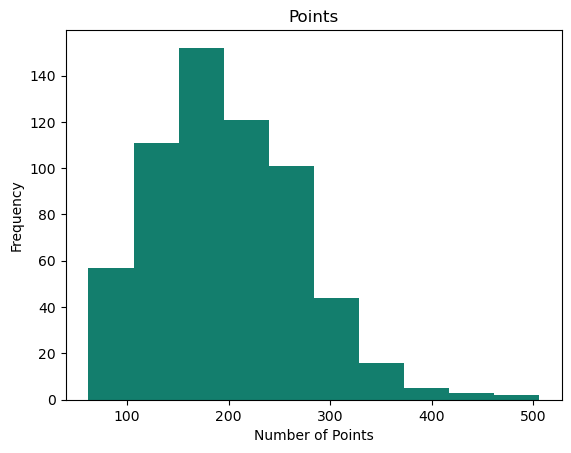

In [26]:
plt.hist(df['Points'], color = color1)
plt.xlabel('Number of Points')
plt.ylabel('Frequency')
plt.title('Points')

Text(0.5, 1.0, 'Words')

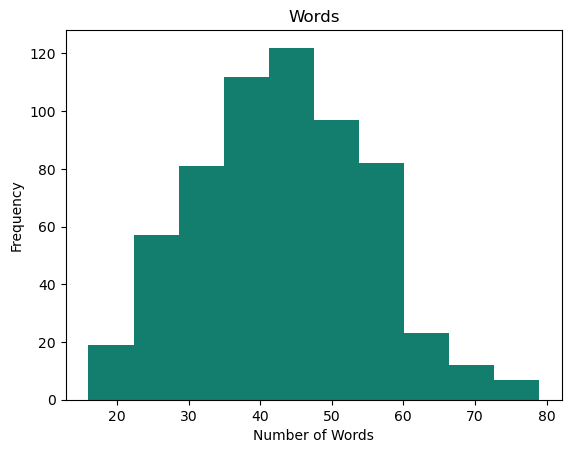

In [27]:
plt.hist(df['Words'], color = color1)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Words')

Text(0.5, 1.0, 'Pangrams')

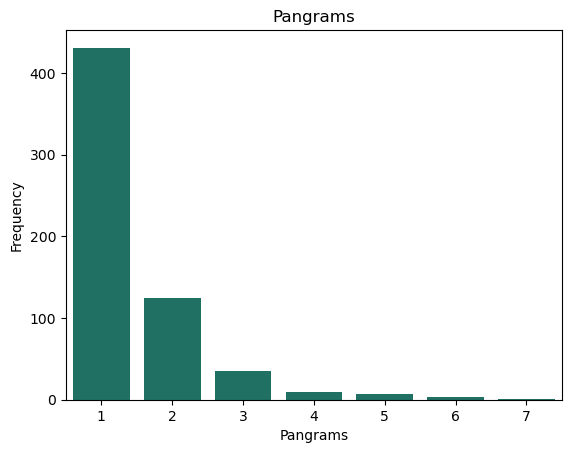

In [28]:
sns.countplot(x = df['Pangrams'], color = color1)
plt.xlabel('Pangrams')
plt.ylabel('Frequency')
plt.title('Pangrams')

Text(0.5, 1.0, 'Vowels')

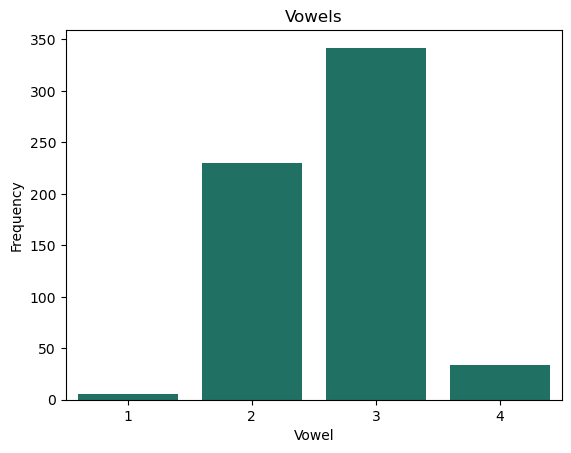

In [29]:
sns.countplot(x = df['Number of Vowels'], color = color1)
plt.xlabel('Vowel')
plt.ylabel('Frequency')
plt.title('Vowels')

Text(0.5, 1.0, 'Letter Frequencies of Other Six Letters')

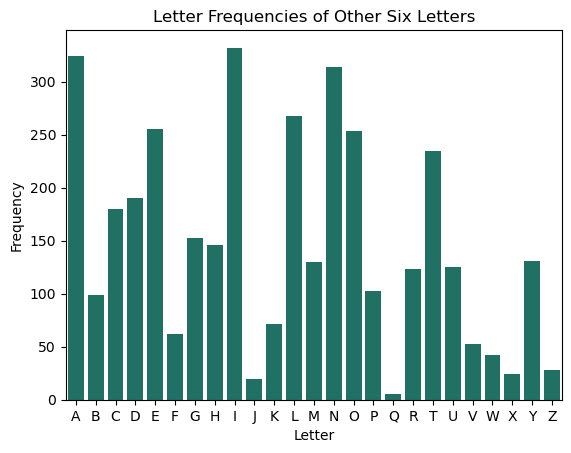

In [54]:
letters = df[['Letter 1', 'Letter 2', 'Letter 3', 'Letter 4', 'Letter 5', 'Letter 6']].values.flatten()
sns.countplot(x = sorted(letters), color = color1)
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Letter Frequencies of Other Six Letters')

Text(0.5, 1.0, 'Letter Frequencies of Center Letter')

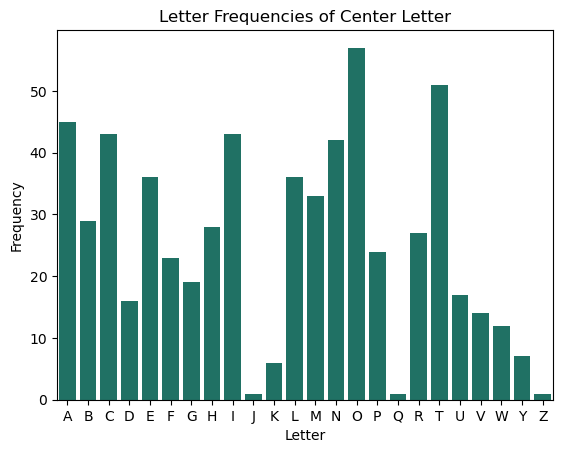

In [55]:
letters = df['Center Letter'].values.flatten()
sns.countplot(x = sorted(letters), color = color1)
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Letter Frequencies of Center Letter')

C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\3977761960.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df['Bingo'], palette = [color1, color2])
C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\3977761960.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Bingo', 'Bingo'])


Text(0.5, 1.0, 'Bingo')

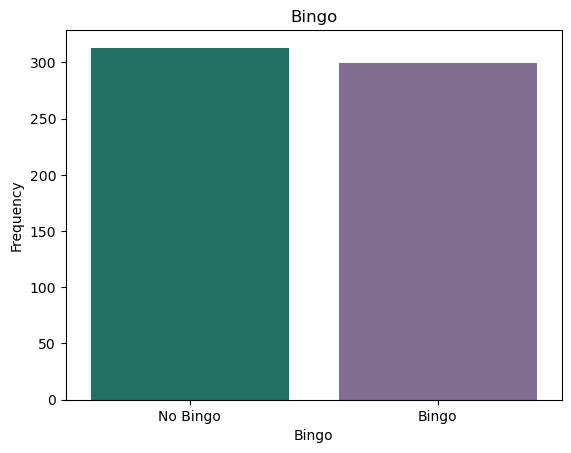

In [30]:
ax = sns.countplot(x = df['Bingo'], palette = [color1, color2])
ax.set_xticklabels(['No Bingo', 'Bingo'])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo')

Text(0.5, 1.0, 'Bingo and Other Six Letters')

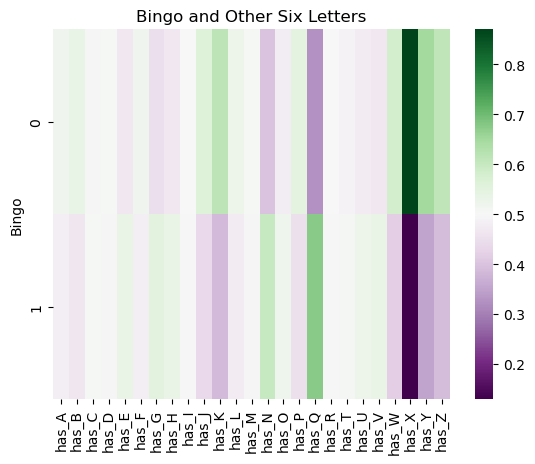

In [31]:
table = data.groupby('Bingo')[other_letter_labels].mean()
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Other Six Letters')

Text(0.5, 1.0, 'Bingo and Center Letter')

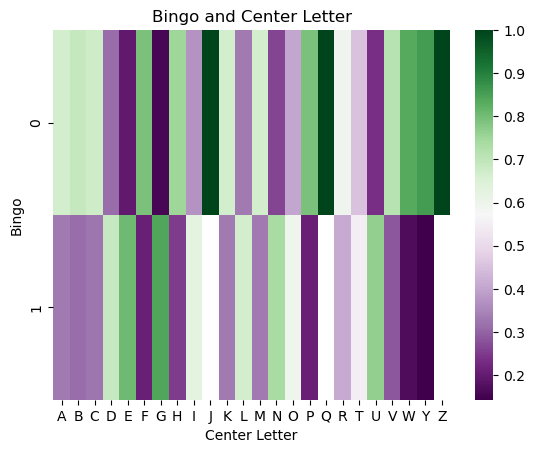

In [32]:
table = pd.pivot_table(df[['Bingo', 'Center Letter']], index = ['Bingo'], columns = ['Center Letter'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Center Letter')

Text(0.5, 1.0, 'Bingo and Number of Vowels')

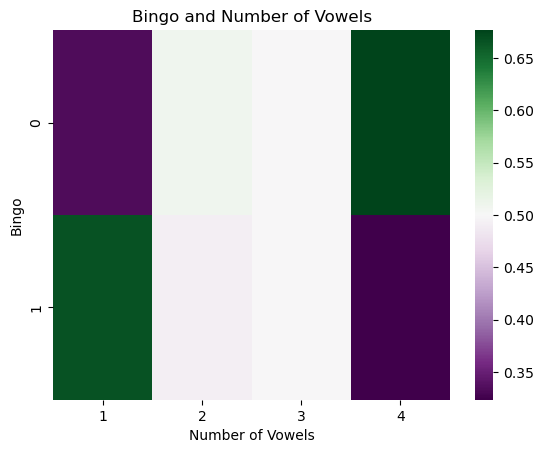

In [33]:
table = pd.pivot_table(df[['Bingo', 'Number of Vowels']], index = ['Bingo'], columns = ['Number of Vowels'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Number of Vowels')

Text(0.5, 1.0, 'Bingo and Number of Pangrams')

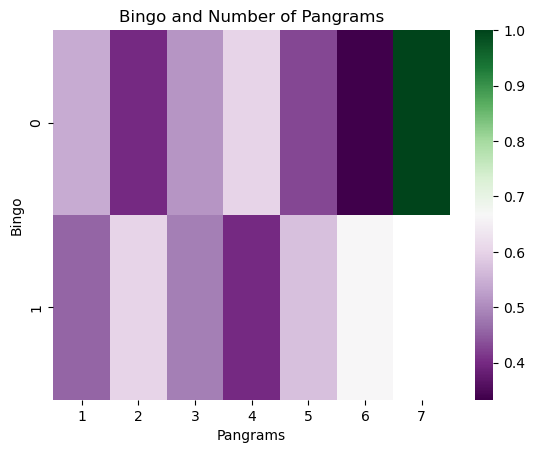

In [34]:
table = pd.pivot_table(df[['Bingo', 'Pangrams']], index = ['Bingo'], columns = ['Pangrams'], values = ['Bingo'], aggfunc = np.size)
table = table.apply(lambda x : x / x.sum())
sns.heatmap(table, cmap = div_color).set_title('Bingo and Number of Pangrams')

C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\3719252040.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y = df['Points'], x = df['Bingo'], palette = [color1, color2])
C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\3719252040.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Bingo', 'Bingo'])


[Text(0, 0, 'No Bingo'), Text(1, 0, 'Bingo')]

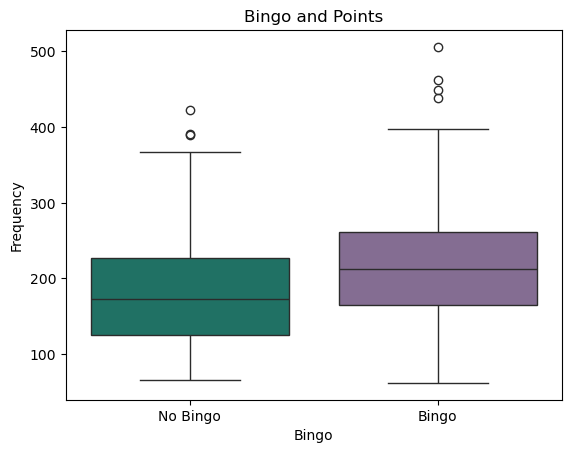

In [35]:
ax = sns.boxplot(y = df['Points'], x = df['Bingo'], palette = [color1, color2])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo and Points')
ax.set_xticklabels(['No Bingo', 'Bingo'])

C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\4139120210.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y = df['Words'], x = df['Bingo'], palette = [color1, color2])
C:\Users\morrism\AppData\Local\Temp\ipykernel_16448\4139120210.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Bingo', 'Bingo'])


[Text(0, 0, 'No Bingo'), Text(1, 0, 'Bingo')]

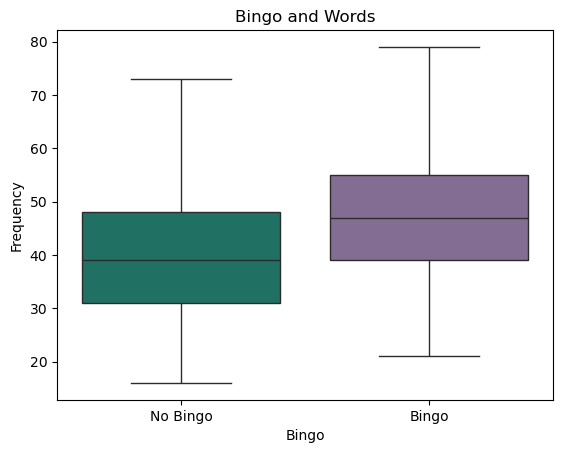

In [36]:
ax = sns.boxplot(y = df['Words'], x = df['Bingo'], palette = [color1, color2])
plt.xlabel('Bingo')
plt.ylabel('Frequency')
plt.title('Bingo and Words')
ax.set_xticklabels(['No Bingo', 'Bingo'])

In [95]:
num_tests = 3 + len(other_letter_labels) + len(center_letter_encoded.columns)
t, p = stats.ttest_ind(df[df['Bingo'] == 0]['Points'], df[df['Bingo'] == 1]['Points'])
print(f"Points\t\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")
t, p = stats.ttest_ind(df[df['Bingo'] == 0]['Words'], df[df['Bingo'] == 1]['Words'])
print(f"Words\t\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")
for l in center_letter_encoded.columns:
    combination = pd.crosstab(data['Bingo'], data[l])
    chi, p, x, x = stats.chi2_contingency(combination)
    print(f"{l:<10}\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")

Points		 p-value: 3.6841023114644797e-09        	 t-stat: -5.9855277130985245 	 significant: True
Words		 p-value: 4.716572829529154e-14         	 t-stat: -7.722233035341     	 significant: True
center_A  	 p-value: 0.0433275885132668            	 t-stat: -7.722233035341     	 significant: False
center_B  	 p-value: 0.07415406016103455           	 t-stat: -7.722233035341     	 significant: False
center_C  	 p-value: 0.03844455833988283           	 t-stat: -7.722233035341     	 significant: False
center_D  	 p-value: 0.17597748620131495           	 t-stat: -7.722233035341     	 significant: False
center_E  	 p-value: 0.00018376866583605045        	 t-stat: -7.722233035341     	 significant: True
center_F  	 p-value: 0.014397927406456117          	 t-stat: -7.722233035341     	 significant: False
center_G  	 p-value: 0.003831738877140536          	 t-stat: -7.722233035341     	 significant: False
center_H  	 p-value: 0.01637896679599824           	 t-stat: -7.722233035341     	 significa

In [94]:
for l in other_letter_labels:
    combination = pd.crosstab(data['Bingo'], data[l])
    chi, p, x, x = stats.chi2_contingency(combination)
    print(f"{l:<10}\t p-value: {p:<30}\t t-stat: {t:<20}\t significant: {p<(0.05/num_tests)}")

has_A     	 p-value: 0.3148185700258302            	 t-stat: -7.722233035341     	 significant: False
has_B     	 p-value: 0.4105163058047834            	 t-stat: -7.722233035341     	 significant: False
has_C     	 p-value: 0.9500911713998116            	 t-stat: -7.722233035341     	 significant: False
has_D     	 p-value: 0.9578792457087715            	 t-stat: -7.722233035341     	 significant: False
has_E     	 p-value: 0.14051063543934178           	 t-stat: -7.722233035341     	 significant: False
has_F     	 p-value: 0.7977614079553365            	 t-stat: -7.722233035341     	 significant: False
has_G     	 p-value: 0.13388731777176813           	 t-stat: -7.722233035341     	 significant: False
has_H     	 p-value: 0.33727495407895713           	 t-stat: -7.722233035341     	 significant: False
has_I     	 p-value: 0.9985891226208374            	 t-stat: -7.722233035341     	 significant: False
has_J     	 p-value: 0.7301008310357835            	 t-stat: -7.722233035341     	

'center_A'

### Data Modeling and Prediction
- create and run model
- train-test split

### Results Analysis
- write stuff
- make presentation